In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy, persim
from ripser import ripser

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') 

## Create data set in R^2

In [7]:
a = np.zeros((11,1))
b = np.zeros((11,1))

a[:3] = np.array([[0.45,.47,.38]]).T
b[:3] = np.array([[0.65,.62,.61]]).T

a[3:9] = np.array([[.65,.75,.74,.55,.69,.69]]).T
b[3:9] = np.array([[0.5,.54,.45,.57,.55,.43]]).T

a[9:] = np.array([[.25,.34]]).T
b[9:] = np.array([[0.43,.40]]).T


num_points = len(a)

## Plot Data points

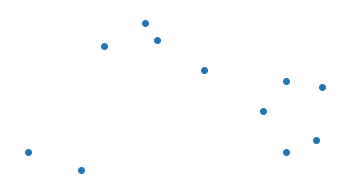

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(a,b)

plt.axis("off")
ax.set_aspect(1.0)
#plt.savefig("dots.pdf",format="pdf")

## Draw epsilon balls around each point

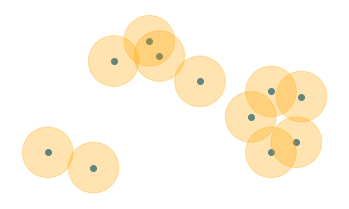

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

eps = .1

plt.axis("off")


for i in np.arange(num_points):
    c = plt.Circle((a[i], b[i]), radius=eps/2, color='orange', alpha=.3)
    ax.add_patch(c)

ax.scatter(a,b)

ax.set_aspect(1.0)

#plt.savefig("circles.pdf",format="pdf")

## Draw simplicial complex

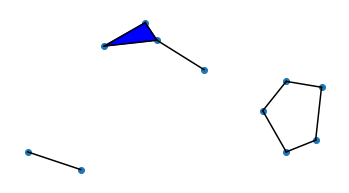

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.axis("off")

ax.scatter(a,b)


ab = np.hstack((a,b))
D = scipy.spatial.distance.cdist(ab,ab)

for i in np.arange(num_points):
    for j in np.arange(i):
        if D[i,j] < eps:
            ax.plot([a[i],a[j]],[b[i],b[j]],color="black")
            
for i in np.arange(num_points):
    for j in np.arange(i):
        for k in np.arange(j):
            if D[i,j] < eps and D[i,k] < eps and D[j,k] < eps:
                ax.fill([a[i],a[j],a[k]],[b[i],b[j],b[k]],color="blue")

ax.set_aspect(1.0)

#plt.savefig("simplicial_complex.pdf",format="pdf")

## Draw balls and simplicial complexes for any epsilon

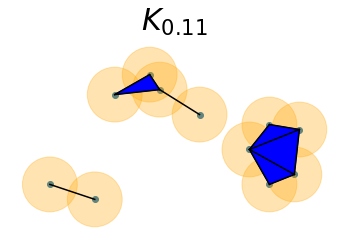

In [13]:
eps = 0.11

fig = plt.figure()
ax = fig.add_subplot(111)

plt.axis("off")

for i in np.arange(num_points):
    c = plt.Circle((a[i], b[i]), radius=eps/2, color='orange', alpha=.3)
    ax.add_patch(c)

ax.scatter(a,b)

ab = np.hstack((a,b))
D = scipy.spatial.distance.cdist(ab,ab)

for i in np.arange(num_points):
    for j in np.arange(i):
        if D[i,j] < eps:
            ax.plot([a[i],a[j]],[b[i],b[j]],color="black")
            
for i in np.arange(num_points):
    for j in np.arange(i):
        for k in np.arange(j):
            if D[i,j] < eps and D[i,k] < eps and D[j,k] < eps:
                ax.fill([a[i],a[j],a[k]],[b[i],b[j],b[k]],color="blue")

ax.set_aspect(1.0)

ax.set_title("$K_{"+str(round(eps,2))+"}$",fontsize=30)

plt.savefig("simplicial_complex_eps_"+str(round(100*eps)).zfill(2)+".pdf",format="pdf")



## Use Ripser to compute the persistent homology

Text(0.5, 1.0, 'Persistence Diagram')

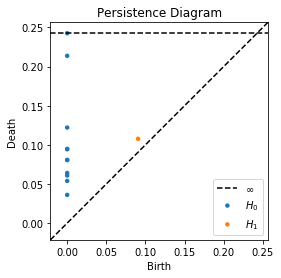

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

dgms = ripser(np.hstack((a,b)))['dgms']
persim.plot_diagrams(dgms,ax=ax)

ax.set_title("Persistence Diagram")

#plt.savefig("PD.pdf",format="pdf")